**User Instuctions**


1.   Run each section step by step
2.   Start from Step 1 web scraping and then do Step 2 Data Processing
3.   Step 3 Can be ignored for user interaction functioanlities
4.   In order to visually see the EDA diagrams, Step 3 can be run








# **Step1- Webscraping**

I am doing web scrabing from Booking.com using selenium. For the destination city i have choosen London and for trip date i have choosen 21 October, 2023. There were few challenges like slow content loading, dynamic contenents for data scrabing from Booking.com. As there are few data, i am using CSV file to store these data for future usage.



In [ ]:
!pip install selenium selenium-stealth selectolax
!pip install webdriver_manager


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.2/400.2 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.9 MB/s eta 0:00:00


In [ ]:
from asyncio import wait
import datetime
import os
from selenium import webdriver
from selenium.webdriver.support import expected_conditions as EC
from selenium_stealth import stealth
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selectolax.lexbor import LexborHTMLParser
import time
import json
import csv
import uuid
import time
import pandas as pd
import numpy as np

In [ ]:
def start_selenimum(url: str):
    # optional for windows POC project for saving data;
    # service = Service(executable_path='chromedriver')

    options = webdriver.ChromeOptions()
    options.add_argument('start-maximized')
    options.add_argument('--headless')
    options.add_argument("window-size=1200,3000")
    options.add_argument('--no-sandbox')
    options.add_experimental_option('excludeSwitches', ['enable-automation'])
    options.add_experimental_option('useAutomationExtension', False)

    # driver = webdriver.Chrome(service=service, options=options)
    driver = webdriver.Chrome(options=options)

    stealth(
        driver,
        user_agent='Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
        languages=['en-US', 'en'],
        vendor='Google Inc.',
        platform='Win32',
        webgl_vendor='Intel Inc.',
        renderer='Intel Iris OpenGL Engine',
        fix_hairline=True,
    )

    driver.get(url)
    time.sleep(2)

    return driver

In [ ]:
def store_parsed_data(driver: webdriver):
    if os.path.exists("flight-data.csv"):
        os.remove("flight-data.csv")
    parser = LexborHTMLParser(driver.page_source)
    flights = parser.root.css(
        '.Flights-Results-FlightResultItem')

    with open('flight-data.csv', '+a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['flight_company',
                         'depature_time', 'arrival_time', 'duration', 'price', 'stops_count', 'stops_over'])
        for flight in flights:
            flight_company = flight.css_first(
                '.carrier').css_first('.bottom').text(strip=True)
            depature_time = flight.css_first('.depart').css_first('.top').css_first(
                '.depart-time').text(strip=True) + ' ' + flight.css_first('.depart').css_first('.top').css_first('.time-meridiem').text(strip=True)
            arrival_time = flight.css_first('.return').css_first('.top').css_first(
                '.arrival-time').text(strip=True) + ' ' + flight.css_first('.return').css_first('.top').css_first('.time-meridiem').text(strip=True)
            duration = flight.css_first(
                '.duration').text(strip=True)
            stops = flight.css_first(
                '.stops').css_first('.stops').text(strip=True)

            stops_over = ''
            stops_count = 0

            if stops != 'nonstop':
                stops_details = flight.css_first(
                    '.stops').css_first('.stops').css('span')
                for stop in stops_details:
                    stops_count = stops_count + 1
                    stops_over = f'{stops_over} {stop.attributes["title"]} {"@---@" if stops_count > 0 else "" }'

            price = flight.css_first(
                '.Flights-Results-FlightPriceSection').css_first('.price-text').text(strip=True)
            writer.writerow([flight_company,
                            depature_time, arrival_time, duration, price, stops_count, stops_over.strip().lstrip('@---@')])


In [ ]:
def scrap_data(driver: webdriver):
    while driver.execute_script("return document.readyState") != "complete":
        pass
    time.sleep(10)
    element = driver.find_element(
        By.CLASS_NAME, "moreButton")
    driver.execute_script("arguments[0].scrollIntoView();", element)

    for x in range(1, 6):
        element = driver.find_element(
            By.CLASS_NAME, "moreButton")
        driver.execute_script("arguments[0].click();", element)
        time.sleep(30)
        driver.execute_script("arguments[0].scrollIntoView();", element)

    store_parsed_data(driver)

In [ ]:
url = f'https://booking.kayak.com/flights/HEL-LON/2023-10-21?sort=bestflight_a'
driver = start_selenimum(url)
try:
  scrap_data(driver)
except Exception as ex:
  print(ex)
  driver.quit()

# **Step 2 - Data processing**

On this step data will be prepared for analysis.


1.   Null and missing and duplicates will be checked and removed from dataframe
2.   Value will to be converted for duration, price, deperature and arrival time




In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

df = pd.read_csv('flight-data.csv')
df

,flight_company,depature_time,arrival_time,duration,price,stops_count,stops_over
0,Ryanair,10:50 pm,11:50 pm,3h 00m,$91,0,NaN
1,Finnair,4:00 pm,5:05 pm,3h 05m,$159,0,NaN
2,Finnair,7:40 pm,8:40 pm,3h 00m,$159,0,NaN
3,Finnair,8:00 am,9:10 am,3h 10m,$186,0,NaN
4,Finnair,2:05 pm,3:10 pm,3h 05m,$186,0,NaN
...,...,...,...,...,...,...,...
85,KLM,7:00 am,10:45 am,5h 45m,$599,1,"1h 40m layover, <b>Amsterdam Schiphol</b> @---@"
86,Austrian Airlines,7:00 am,2:20 pm,9h 20m,$442,2,"2h 10m layover, <b>Kastrup Copenhagen</b> @---..."
87,Lufthansa,11:15 am,6:25 pm,9h 10m,$455,2,"55m layover, <b>Kastrup Copenhagen</b> @---@ 3..."
88,Multiple Airlines,5:25 am,2:50 pm,11h 25m,$230,2,"40m layover, <b>Riga Intl</b> @---@ 6h 20m lay..."


In [ ]:
df.isnull().sum()

flight_company    0
depature_time     0
arrival_time      0
duration          0
price             0
stops_count       0
stops_over        9
dtype: int64

In [ ]:
df.dtypes
# df['stops_over'] = df['stops_over'].apply(lambda item: '' if item == 'nan' else str(item).rstrip('@---@').strip())
# df

flight_company    object
depature_time     object
arrival_time      object
duration          object
price             object
stops_count        int64
stops_over        object
dtype: object

In [ ]:
df['price'] = df['price'].str.strip('$')
df


,flight_company,depature_time,arrival_time,duration,price,stops_count,stops_over
0,Ryanair,10:50 pm,11:50 pm,3h 00m,91,0,NaN
1,Finnair,4:00 pm,5:05 pm,3h 05m,159,0,NaN
2,Finnair,7:40 pm,8:40 pm,3h 00m,159,0,NaN
3,Finnair,8:00 am,9:10 am,3h 10m,186,0,NaN
4,Finnair,2:05 pm,3:10 pm,3h 05m,186,0,NaN
...,...,...,...,...,...,...,...
85,KLM,7:00 am,10:45 am,5h 45m,599,1,"1h 40m layover, <b>Amsterdam Schiphol</b> @---@"
86,Austrian Airlines,7:00 am,2:20 pm,9h 20m,442,2,"2h 10m layover, <b>Kastrup Copenhagen</b> @---..."
87,Lufthansa,11:15 am,6:25 pm,9h 10m,455,2,"55m layover, <b>Kastrup Copenhagen</b> @---@ 3..."
88,Multiple Airlines,5:25 am,2:50 pm,11h 25m,230,2,"40m layover, <b>Riga Intl</b> @---@ 6h 20m lay..."


In [ ]:
df.dtypes

flight_company    object
depature_time     object
arrival_time      object
duration          object
price             object
stops_count        int64
stops_over        object
dtype: object

In [ ]:
df['price'] = pd.to_numeric(df['price'])
df.dtypes

flight_company    object
depature_time     object
arrival_time      object
duration          object
price              int64
stops_count        int64
stops_over        object
dtype: object

In [ ]:
df['duration']

0      3h 00m
1      3h 05m
2      3h 00m
3      3h 10m
4      3h 05m
       ...   
85     5h 45m
86     9h 20m
87     9h 10m
88    11h 25m
89     8h 22m
Name: duration, Length: 90, dtype: object

In [ ]:
df['duration'] = df['duration'].str.split(' ')
df['duration'] = df['duration'].apply(lambda item: [str(item[0]).lstrip('0'), str(
    item[1]).lstrip('0') if len(str(item[1]).lstrip('0')) > 1 else '0m'])
df['duration'] = df['duration'].str.join(' ')
df['duration'] = df['duration'].str.replace(
    "h", '*60').str.replace('m', '*1').str.replace(' ', '+').apply(eval)
df['duration']

0     180
1     185
2     180
3     190
4     185
     ... 
85    345
86    560
87    550
88    685
89    502
Name: duration, Length: 90, dtype: int64

In [ ]:
df['depature_time'] = df['depature_time'].apply(lambda depature: f'2012-12-12 {depature}')
df['depature_time'] = pd.to_datetime(df['depature_time'], format='%Y-%m-%d %I:%M %p')
df['arrival_time'] = df['arrival_time'].apply(lambda depature: f'2012-12-12 {depature}')
df['arrival_time'] = pd.to_datetime(df['arrival_time'], format='%Y-%m-%d %I:%M %p')
df['arrival_time']

0    2012-12-12 23:50:00
1    2012-12-12 17:05:00
2    2012-12-12 20:40:00
3    2012-12-12 09:10:00
4    2012-12-12 15:10:00
             ...        
85   2012-12-12 10:45:00
86   2012-12-12 14:20:00
87   2012-12-12 18:25:00
88   2012-12-12 14:50:00
89   2012-12-12 13:57:00
Name: arrival_time, Length: 90, dtype: datetime64[ns]

In [ ]:
df.dtypes

flight_company            object
depature_time     datetime64[ns]
arrival_time      datetime64[ns]
duration                   int64
price                      int64
stops_count                int64
stops_over                object
dtype: object

In [ ]:
df['flight_company'] = df['flight_company'].astype('string')
df['stops_over'] = df['stops_over'].astype('string')
df.dtypes

flight_company            string
depature_time     datetime64[ns]
arrival_time      datetime64[ns]
duration                   int64
price                      int64
stops_count                int64
stops_over                string
dtype: object

In [ ]:
df

,flight_company,depature_time,arrival_time,duration,price,stops_count,stops_over
0,Ryanair,2012-12-12 22:50:00,2012-12-12 23:50:00,180,91,0,<NA>
1,Finnair,2012-12-12 16:00:00,2012-12-12 17:05:00,185,159,0,<NA>
2,Finnair,2012-12-12 19:40:00,2012-12-12 20:40:00,180,159,0,<NA>
3,Finnair,2012-12-12 08:00:00,2012-12-12 09:10:00,190,186,0,<NA>
4,Finnair,2012-12-12 14:05:00,2012-12-12 15:10:00,185,186,0,<NA>
...,...,...,...,...,...,...,...
85,KLM,2012-12-12 07:00:00,2012-12-12 10:45:00,345,599,1,"1h 40m layover, <b>Amsterdam Schiphol</b> @---@"
86,Austrian Airlines,2012-12-12 07:00:00,2012-12-12 14:20:00,560,442,2,"2h 10m layover, <b>Kastrup Copenhagen</b> @---..."
87,Lufthansa,2012-12-12 11:15:00,2012-12-12 18:25:00,550,455,2,"55m layover, <b>Kastrup Copenhagen</b> @---@ 3..."
88,Multiple Airlines,2012-12-12 05:25:00,2012-12-12 14:50:00,685,230,2,"40m layover, <b>Riga Intl</b> @---@ 6h 20m lay..."


# **Step 3 – Exploratory data analysis (EDA)**
On this step based on data, relationships and patterns will be indentifided based on both graphical and non graphical ways.

In [ ]:
!pip install Seaborn

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [ ]:
df.shape

(90, 7)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,90.0,424.355556,137.306212,180.0,330.0,412.5,543.75,685.0
price,90.0,263.000000,120.890516,91.0,178.0,217.5,376.25,623.0
stops_count,90.0,1.133333,0.564890,0.0,1.0,1.0,1.00,2.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   flight_company  90 non-null     string        
 1   depature_time   90 non-null     datetime64[ns]
 2   arrival_time    90 non-null     datetime64[ns]
 3   duration        90 non-null     int64         
 4   price           90 non-null     int64         
 5   stops_count     90 non-null     int64         
 6   stops_over      81 non-null     string        
dtypes: datetime64[ns](2), int64(3), string(2)
memory usage: 5.0 KB


<ipython-input-67-aa4f4450a243>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

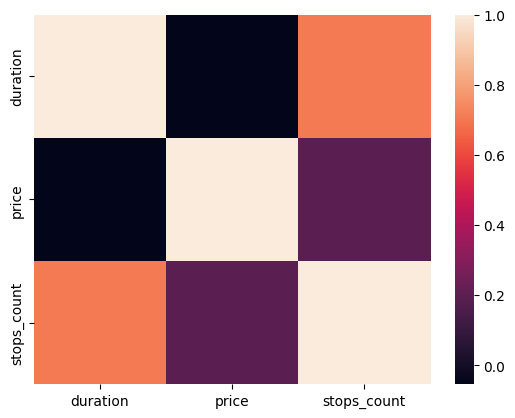

In [ ]:
sns.heatmap(df.corr())

<Axes: xlabel='flight_company', ylabel='price'>

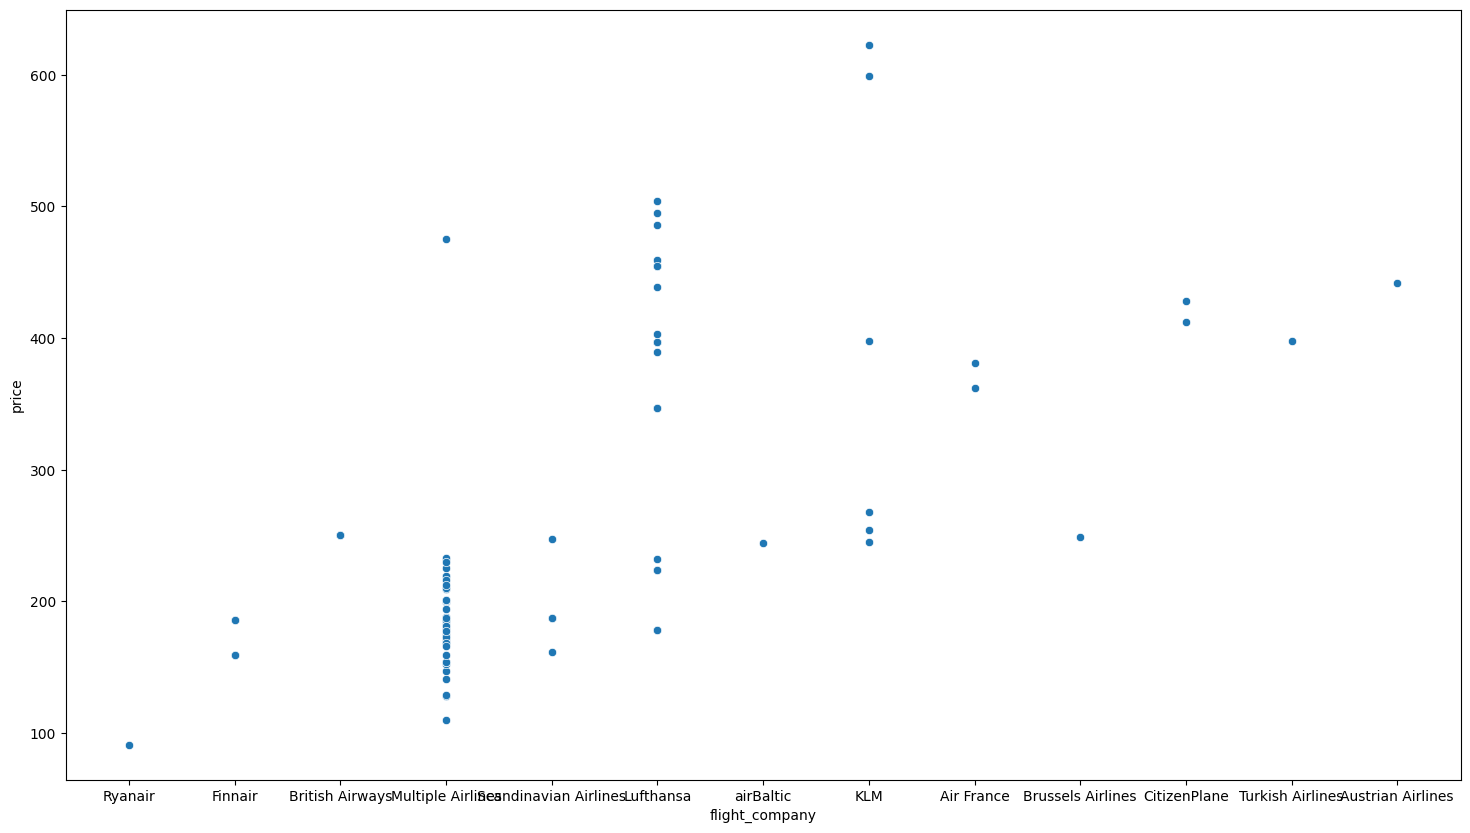

In [ ]:
plt.figure(figsize=(18,10))
sns.scatterplot(df, x='flight_company', y='price')

<Axes: xlabel='flight_company', ylabel='count'>

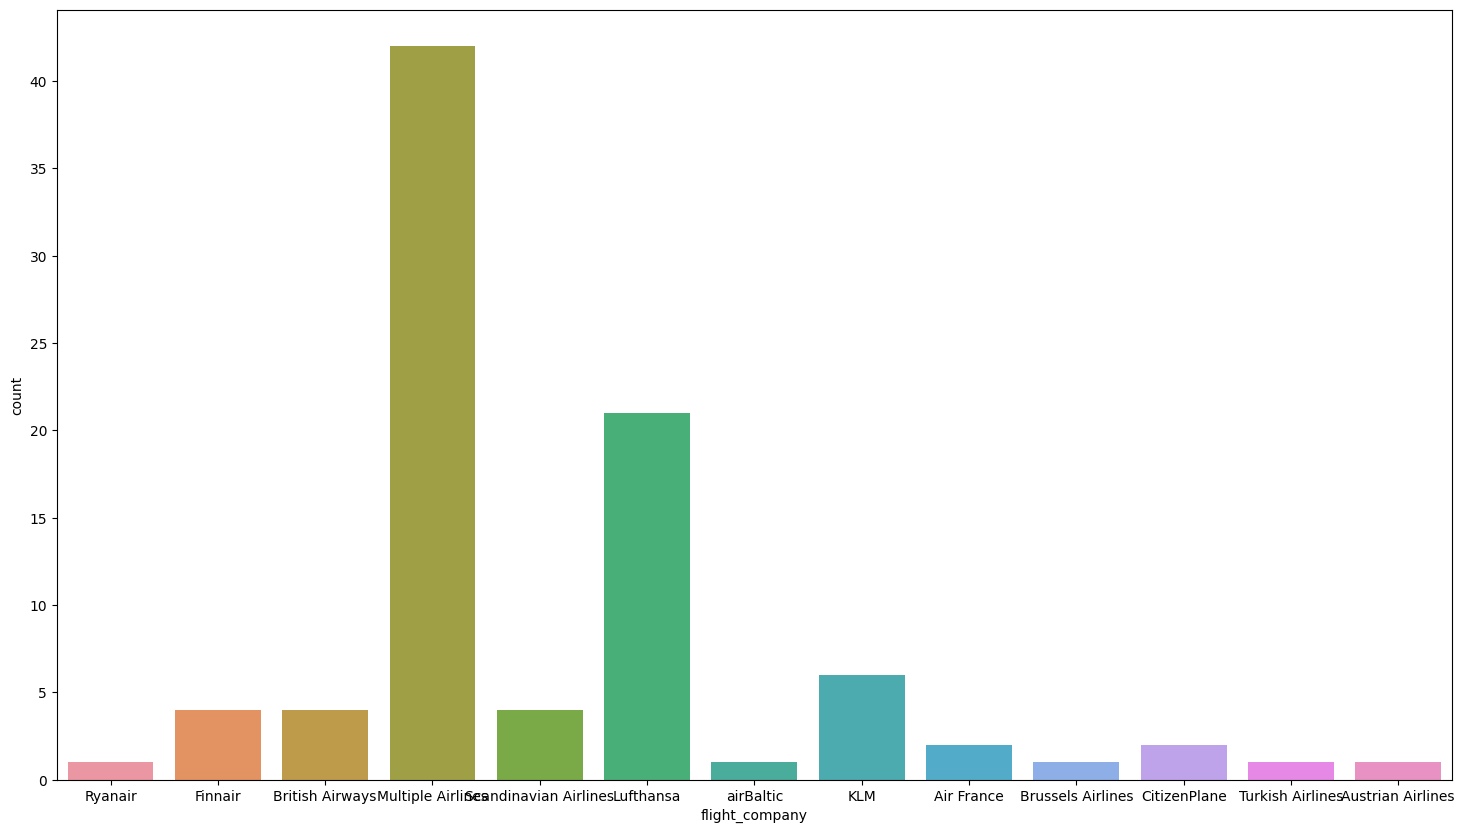

In [ ]:
plt.figure(figsize=(18,10))
sns.countplot(df,x='flight_company')

<Axes: xlabel='duration', ylabel='price'>

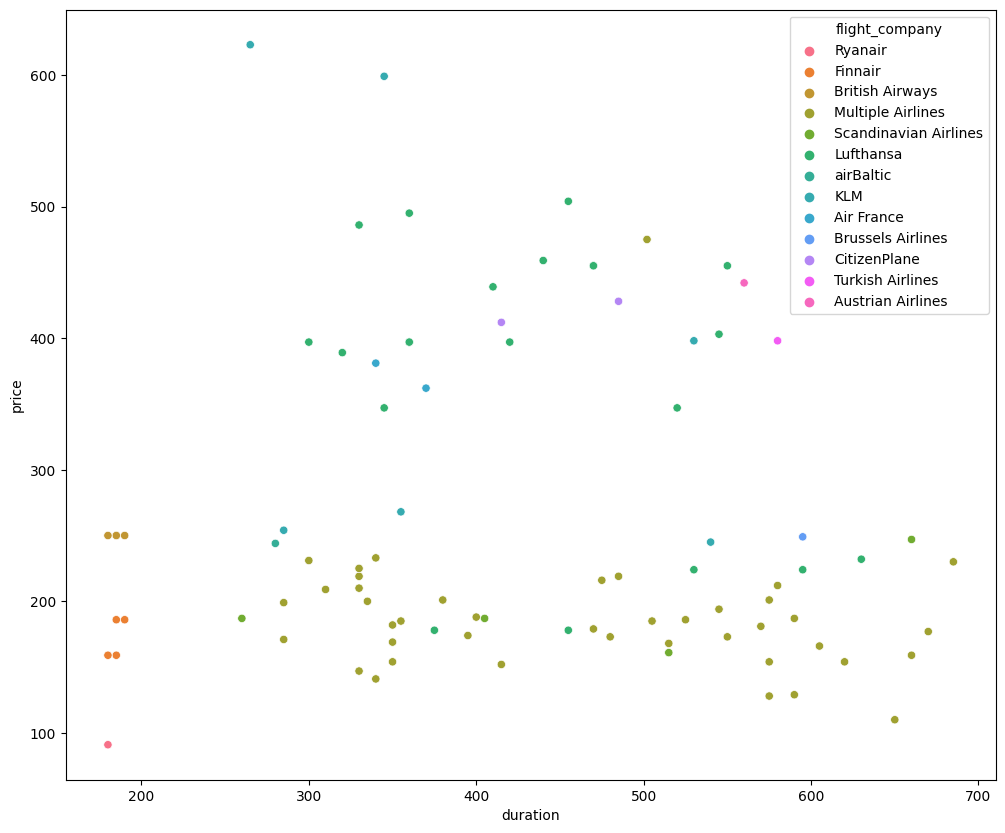

In [ ]:
plt.figure(figsize=(12,10))
sns.scatterplot(df,x='duration', y='price', hue='flight_company')

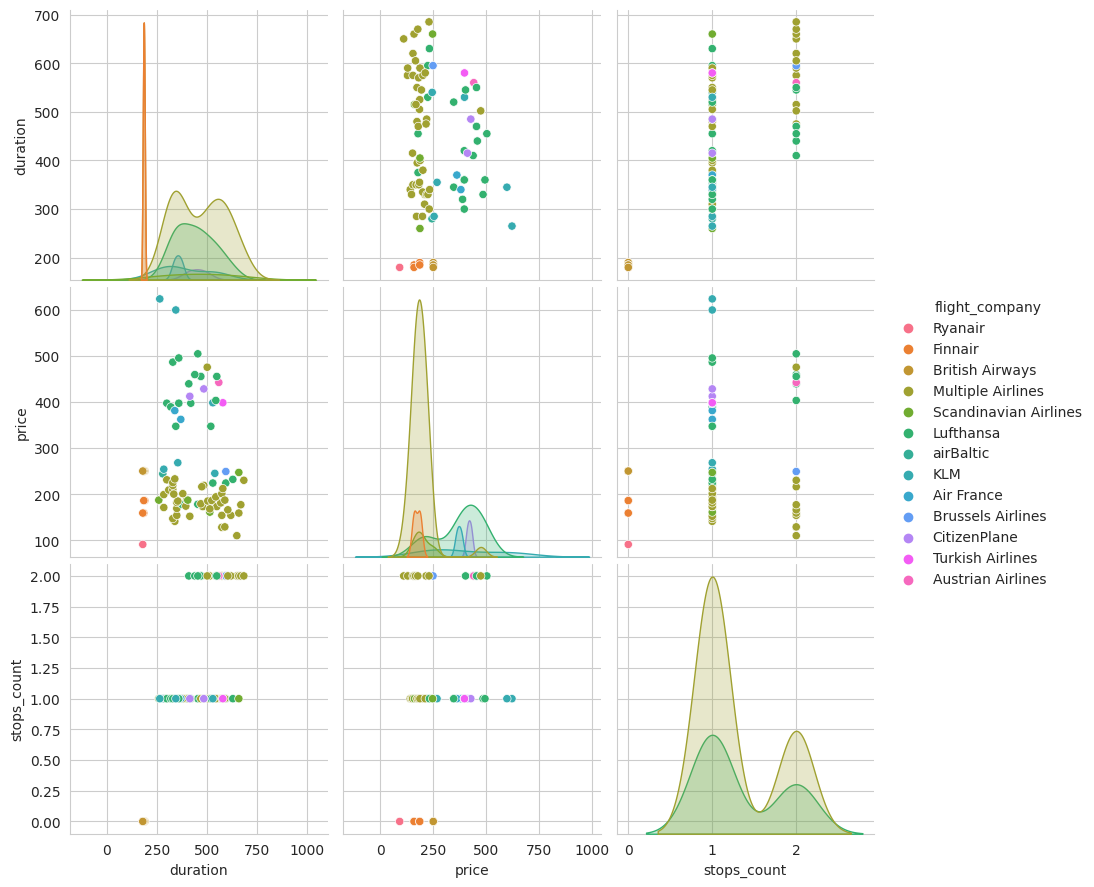

In [ ]:
sns.set_style('whitegrid');
sns.pairplot(df, hue= 'flight_company', height = 3)
plt.show()

# **Step 4 – Interaction with the user**
Here based on collected data, user would be able to find prefered results

In [ ]:
filtered_df = df

In [ ]:
filtered_df = df

try:
    min_price = int(input("Enter Minimum Price(int):"))
    filtered_df = filtered_df[filtered_df['price'] >= min_price]
except Exception as ex:
    print(ex)
    min_price = None

try:
    max_price = int(input("Enter Maximum Price(int):"))
    filtered_df = filtered_df[filtered_df['price'] <= max_price]
except Exception as ex:
    print(ex)
    max_price = None

filtered_df

Enter Minimum Price(int):
invalid literal for int() with base 10: ''
Enter Maximum Price(int):100


,flight_company,depature_time,arrival_time,duration,price,stops_count,stops_over
0,Ryanair,2012-12-12 22:50:00,2012-12-12 23:50:00,180,92,0,
1,Ryanair,2012-12-12 23:20:00,2012-12-12 13:25:00,965,73,1,"11h 55m layover, <b>Warsaw Modlin</b>"


In [ ]:
try:
    min_duration = int(input("Enter Minimum Duration(int in hours):"))
    filtered_df = filtered_df[filtered_df['duration'] >= min_duration*60]
except Exception as ex:
    print(ex)
    min_duration = None

try:
    max_duration = int(input("Enter Minimum Duration(int in hours):"))
    filtered_df = filtered_df[filtered_df['duration'] <= max_duration*60]
except Exception as ex:
    print(ex)
    max_duration = None

filtered_df

Enter Minimum Duration(int in hours):4
Enter Minimum Duration(int in hours):
invalid literal for int() with base 10: ''


,flight_company,depature_time,arrival_time,duration,price,stops_count,stops_over
1,Ryanair,2012-12-12 23:20:00,2012-12-12 13:25:00,965,73,1,"11h 55m layover, <b>Warsaw Modlin</b>"
10,Multiple Airlines,2012-12-12 15:45:00,2012-12-12 00:35:00,650,111,2,"1h 15m layover, <b>Stockholm Arlanda</b> @---@..."
11,Lufthansa,2012-12-12 12:50:00,2012-12-12 17:05:00,375,173,1,"1h 40m layover, <b>Munich Franz Josef Strauss</b>"
12,Scandinavian Airlines,2012-12-12 11:15:00,2012-12-12 13:35:00,260,217,1,"40m layover, <b>Kastrup Copenhagen</b>"
13,Multiple Airlines,2012-12-12 15:45:00,2012-12-12 23:20:00,575,133,2,"1h 15m layover, <b>Stockholm Arlanda</b> @---@..."
...,...,...,...,...,...,...,...
86,Multiple Airlines,2012-12-12 08:10:00,2012-12-12 12:40:00,390,390,1,"2h 45m layover, <b>Amsterdam Schiphol</b>"
87,Multiple Airlines,2012-12-12 06:40:00,2012-12-12 11:30:00,410,440,2,"50m layover, <b>Frankfurt am Main</b> @---@ 1h..."
88,Lufthansa,2012-12-12 06:40:00,2012-12-12 10:40:00,360,487,1,"1h 45m layover, <b>Frankfurt am Main</b>"
89,Lufthansa,2012-12-12 06:40:00,2012-12-12 09:40:00,300,552,1,"45m layover, <b>Frankfurt am Main</b>"


In [ ]:
try:
    direct_flight = str(input("Enter Whether Direct Flight or not (True / False):"))
    if direct_flight.lower() == 'true':
        filtered_df = filtered_df[filtered_df['stops_count'] == 0]
    elif direct_flight.lower() == 'false':
        filtered_df = filtered_df[filtered_df['stops_count'] > 0]
except Exception as ex:
    print(ex)
    direct_flight = False

filtered_df

Enter Whether Direct Flight or not (True / False):False


,flight_company,depature_time,arrival_time,duration,price,stops_count,stops_over
1,Ryanair,2012-12-12 23:20:00,2012-12-12 13:25:00,965,73,1,"11h 55m layover, <b>Warsaw Modlin</b>"
10,Multiple Airlines,2012-12-12 15:45:00,2012-12-12 00:35:00,650,111,2,"1h 15m layover, <b>Stockholm Arlanda</b> @---@..."
11,Lufthansa,2012-12-12 12:50:00,2012-12-12 17:05:00,375,173,1,"1h 40m layover, <b>Munich Franz Josef Strauss</b>"
12,Scandinavian Airlines,2012-12-12 11:15:00,2012-12-12 13:35:00,260,217,1,"40m layover, <b>Kastrup Copenhagen</b>"
13,Multiple Airlines,2012-12-12 15:45:00,2012-12-12 23:20:00,575,133,2,"1h 15m layover, <b>Stockholm Arlanda</b> @---@..."
...,...,...,...,...,...,...,...
86,Multiple Airlines,2012-12-12 08:10:00,2012-12-12 12:40:00,390,390,1,"2h 45m layover, <b>Amsterdam Schiphol</b>"
87,Multiple Airlines,2012-12-12 06:40:00,2012-12-12 11:30:00,410,440,2,"50m layover, <b>Frankfurt am Main</b> @---@ 1h..."
88,Lufthansa,2012-12-12 06:40:00,2012-12-12 10:40:00,360,487,1,"1h 45m layover, <b>Frankfurt am Main</b>"
89,Lufthansa,2012-12-12 06:40:00,2012-12-12 09:40:00,300,552,1,"45m layover, <b>Frankfurt am Main</b>"


In [ ]:
try:
    flight_company = str(input("Enter Flight Company:"))
    filtered_df = filtered_df[filtered_df['flight_company'].str.lower() ==
                     flight_company.lower()]
except Exception as ex:
    print(ex)
    flight_company = None

filtered_df

Enter Flight Company:KLM


,flight_company,depature_time,arrival_time,duration,price,stops_count,stops_over
27,KLM,2012-12-12 18:10:00,2012-12-12 20:55:00,285,270,1,"50m layover, <b>Amsterdam Schiphol</b>"
38,KLM,2012-12-12 13:55:00,2012-12-12 17:50:00,355,255,1,"2h 15m layover, <b>Amsterdam Schiphol</b>"
63,KLM,2012-12-12 13:55:00,2012-12-12 20:55:00,540,246,1,"5h 05m layover, <b>Amsterdam Schiphol</b>"


In [ ]:
sort_by = input('Enter sort result by (flight_company, stops_count, duration, price):')
ascending_input = input('Enter sort direction by (ascending/desending):')
ascending = True
if ascending_input.lower() == 'desending':
  ascending = False

print(ascending)
filtered_df.sort_values(by=sort_by, ascending=ascending, inplace=True)

filtered_df

Enter sort result by (flight_company, stops_count, duration, price):duration
Enter sort direction by (ascending/desending):ascending
True


,flight_company,depature_time,arrival_time,duration,price,stops_count,stops_over
27,KLM,2012-12-12 18:10:00,2012-12-12 20:55:00,285,270,1,"50m layover, <b>Amsterdam Schiphol</b>"
38,KLM,2012-12-12 13:55:00,2012-12-12 17:50:00,355,255,1,"2h 15m layover, <b>Amsterdam Schiphol</b>"
63,KLM,2012-12-12 13:55:00,2012-12-12 20:55:00,540,246,1,"5h 05m layover, <b>Amsterdam Schiphol</b>"


In [ ]:
unique_items= df['depature_time'].unique()
unique_airlines= df['flight_company'].unique()

for item in unique_items:
  print(item)

print('##################')

for item in unique_airlines:
  print(item)
prefered_df = df

try:
    prefered_deperature_time = str(input("Enter prefered time (suggestions are above):"))

    if any(str(e) == prefered_deperature_time for e in unique_items):
      prefered_df = df[(df['depature_time'] == prefered_deperature_time)]

    prefered_airline = str(input("Enter prefered ariline (suggestions are above):"))

    if not (prefered_airline is None or prefered_airline == "") :
      prefered_df = df[(df['flight_company'].str.lower() == prefered_airline.lower())]

    try:
      prefered_duration = int(input("Enter trip duration (int in hours):"))
      prefered_df = df[(df['duration'] <= prefered_duration * 60)]
    except:
      prefered_duration = None

except Exception as ex:
    print(ex)

prefered_df

2012-12-12T22:50:00.000000000
2012-12-12T16:00:00.000000000
2012-12-12T19:40:00.000000000
2012-12-12T08:00:00.000000000
2012-12-12T14:05:00.000000000
2012-12-12T12:50:00.000000000
2012-12-12T16:05:00.000000000
2012-12-12T11:15:00.000000000
2012-12-12T12:05:00.000000000
2012-12-12T11:00:00.000000000
2012-12-12T15:45:00.000000000
2012-12-12T05:25:00.000000000
2012-12-12T16:15:00.000000000
2012-12-12T16:10:00.000000000
2012-12-12T18:10:00.000000000
2012-12-12T07:25:00.000000000
2012-12-12T09:00:00.000000000
2012-12-12T06:15:00.000000000
2012-12-12T07:00:00.000000000
2012-12-12T12:00:00.000000000
2012-12-12T13:55:00.000000000
2012-12-12T13:40:00.000000000
2012-12-12T07:35:00.000000000
2012-12-12T06:10:00.000000000
2012-12-12T17:45:00.000000000
2012-12-12T06:20:00.000000000
2012-12-12T07:10:00.000000000
2012-12-12T11:35:00.000000000
2012-12-12T06:40:00.000000000
2012-12-12T10:40:00.000000000
2012-12-12T12:55:00.000000000
2012-12-12T11:25:00.000000000
##################
Ryanair
Finnair
Briti

,flight_company,depature_time,arrival_time,duration,price,stops_count,stops_over
9,Multiple Airlines,2012-12-12 12:50:00,2012-12-12 16:30:00,340,141,1,"2h 15m layover, <b>Stockholm Arlanda</b> @---@"
10,Multiple Airlines,2012-12-12 16:05:00,2012-12-12 19:35:00,330,147,1,"1h 55m layover, <b>Oslo Gardermoen</b> @---@"
12,Multiple Airlines,2012-12-12 12:05:00,2012-12-12 14:50:00,285,171,1,"1h 10m layover, <b>Kastrup Copenhagen</b> @---@"
13,Multiple Airlines,2012-12-12 11:00:00,2012-12-12 14:50:00,350,154,1,"2h 15m layover, <b>Kastrup Copenhagen</b> @---@"
14,Multiple Airlines,2012-12-12 12:05:00,2012-12-12 14:50:00,285,199,1,"1h 10m layover, <b>Kastrup Copenhagen</b> @---@"
15,Multiple Airlines,2012-12-12 12:05:00,2012-12-12 15:55:00,350,169,1,"2h 15m layover, <b>Kastrup Copenhagen</b> @---@"
16,Multiple Airlines,2012-12-12 15:45:00,2012-12-12 23:20:00,575,128,2,"1h 15m layover, <b>Stockholm Arlanda</b> @---@..."
18,Multiple Airlines,2012-12-12 11:00:00,2012-12-12 15:55:00,415,152,1,"3h 20m layover, <b>Kastrup Copenhagen</b> @---@"
20,Multiple Airlines,2012-12-12 11:00:00,2012-12-12 14:50:00,350,182,1,"2h 15m layover, <b>Kastrup Copenhagen</b> @---@"
21,Multiple Airlines,2012-12-12 16:15:00,2012-12-12 19:25:00,310,209,1,"1h 10m layover, <b>Gothenburg Landvetter</b> @..."


In [ ]:
print('Cheapest Flight')

prefered_df.sort_values(by='price')

cheapest = prefered_df.head(1).to_records()[0]

print(f'Airline : {cheapest.flight_company}')
print(f'Price : {cheapest.price}')
print(f'Duration : {cheapest.duration} minutes')
print(f'Type : { "NonStop" if cheapest.stops_count == 0 else "Not NonStop"}')

if cheapest.stops_count > 0 :
  layovers = cheapest.stops_over.replace('<b>', '')
  layovers = layovers.replace('</b>', '')
  layovers = layovers.replace('@---@', '\n')
  print('layovers: ')
  print(layovers)

Cheapest Flight
Airline : Multiple Airlines
Price : 141
Duration : 340 minutes
Type : Not NonStop
layovers: 
2h 15m layover, Stockholm Arlanda 



In [ ]:
print('Fastest Flight')

prefered_df.sort_values(by='duration')

fasted = prefered_df.head(1).to_records()[0]

print(f'Airline : {cheapest.flight_company}')
print(f'Price : {fasted.price}')
print(f'Duration : {fasted.duration} minutes')
print(f'Type : { "NonStop" if fasted.stops_count == 0 else "Not NonStop"}')

if fasted.stops_count > 0 :
  layovers = fasted.stops_over.replace('<b>', '')
  layovers = layovers.replace('</b>', '')
  layovers = layovers.replace('@---@', '\n')
  print('layovers: ')
  print(layovers)

Fastest Flight
Airline : Multiple Airlines
Price : 141
Duration : 340 minutes
Type : Not NonStop
layovers: 
2h 15m layover, Stockholm Arlanda 

